In [1]:
model_dir='/home/craig/Documents/coursera/models'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Here we will load a VGG model, save it locally, and then do transfer learning.  Later we will visualize the layers 
of the previous and retrained models, perhaps conditional on class, and examine saliency/grad maps to understand the retraining.

In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import load_model, Model

In [10]:

vgg_model=VGG19()



In [6]:
#check to see it is here
vgg_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [8]:
model_file=model_dir+'/VGG19'
vgg_model.save(model_file)

INFO:tensorflow:Assets written to: /home/craig/Documents/coursera/models/VGG19/assets


In [4]:
model_file=model_dir+'/VGG19'
vgg=load_model(model_file)

2022-05-25 12:49:20.816342: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-25 12:49:20.816506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-25 12:49:20.817266: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
#check to see if loaded
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

After loading the model we will take the model and build a new model with .......

In [22]:
vgg_input=vgg.input #the input layer
vgg_layers=vgg.layers  # a list of the layers
vgg_layers[1].name #checking an attribute

'block1_conv1'

In [26]:
#building the new model
layer_output=[layer.output for layer in vgg_layers] #this is a list of the outputs of each layer in the model
#layer_output[1] #checking a layer
feature_model=Model(inputs=vgg_input,outputs=layer_output) #this model has the input of vgg, but the outputs of each 
#layer as output

In [39]:
feature_model.layers[2].name #checking the layers
len(feature_model.output)#this model has many outputs
feature_model.summary() #looks the same but has more outputs .. interesting

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [47]:
#Below we are loading  
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

file_name=  '/home/craig/Documents/coursera'+ '/cool_cat.jpeg'
img=image.load_img(file_name,target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=preprocess_input(x)

In [48]:
extracted_features=feature_model(x) #this gives us the outputs from every layer of the network, including input at 0


 shape of f0  (1, 224, 224, 3)


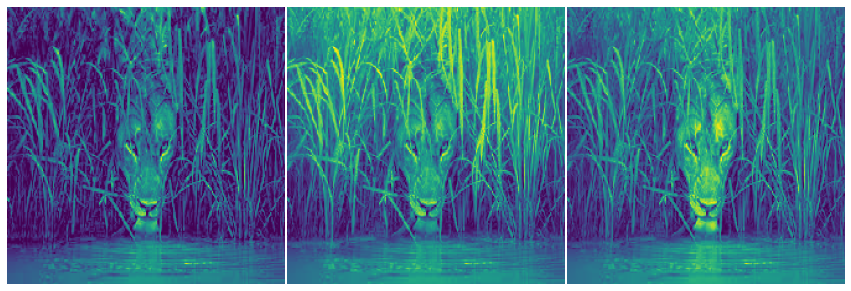

In [50]:
f0=extracted_features[0]  #this is a plot of the three input channels
print('\n shape of f0 ',f0.shape)

images =f0[0,:,:]
plt.figure(figsize=(15,15))
for n in range(3):
    ax=plt.subplot(1,3,n+1)
    plt.imshow(images[:,:,n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)



 shape of f1  (1, 224, 224, 64)


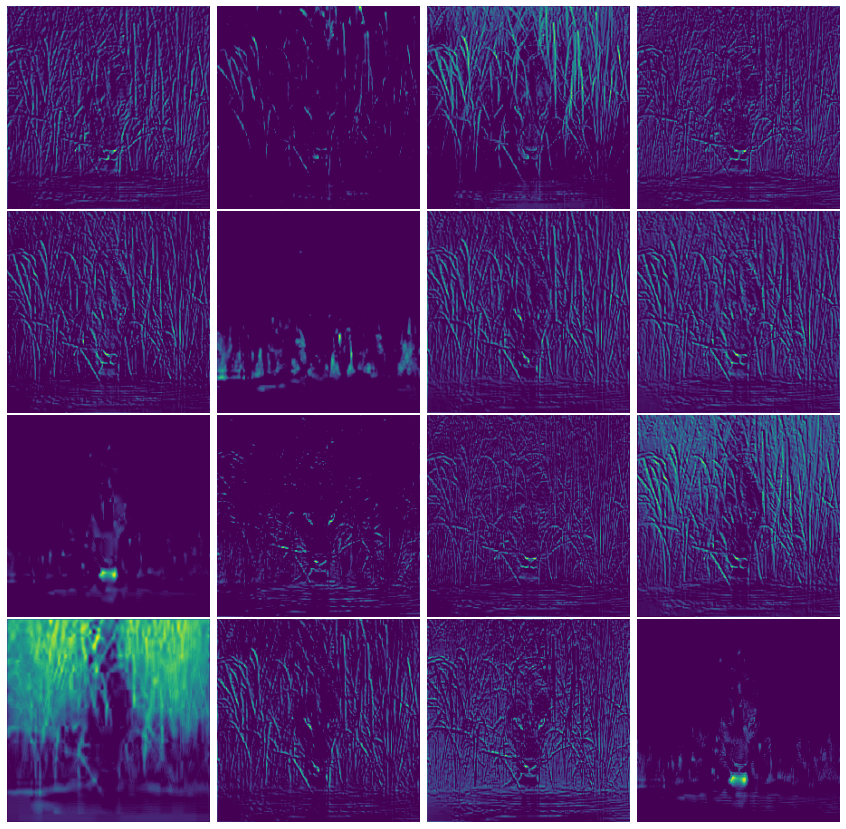

In [51]:
f1=extracted_features[1]  #this is a plot of the three input channels
print('\n shape of f1 ',f1.shape)

images =f1[0,:,:]
plt.figure(figsize=(15,15))
for n in range(16):
    ax=plt.subplot(4,4,n+1)
    plt.imshow(images[:,:,n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [52]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [56]:
#alternative way of making a model where only output is from a given layer
block1=Model(inputs=vgg.inputs,outputs=vgg.get_layer('block1_pool').output)
block1_features=block1.predict(x)

2022-05-25 09:57:22.675688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-25 09:57:22.777583: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2693810000 Hz


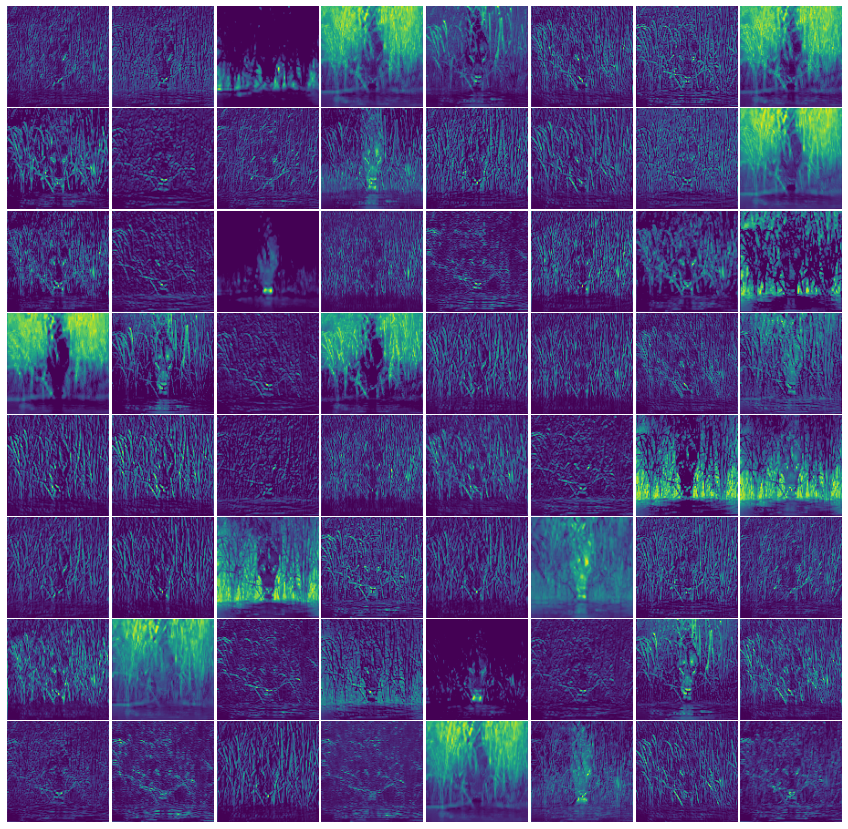

In [57]:
images =block1_features[0,:,:]
plt.figure(figsize=(15,15))
for n in range(64):
    ax=plt.subplot(8,8,n+1)
    plt.imshow(images[:,:,n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

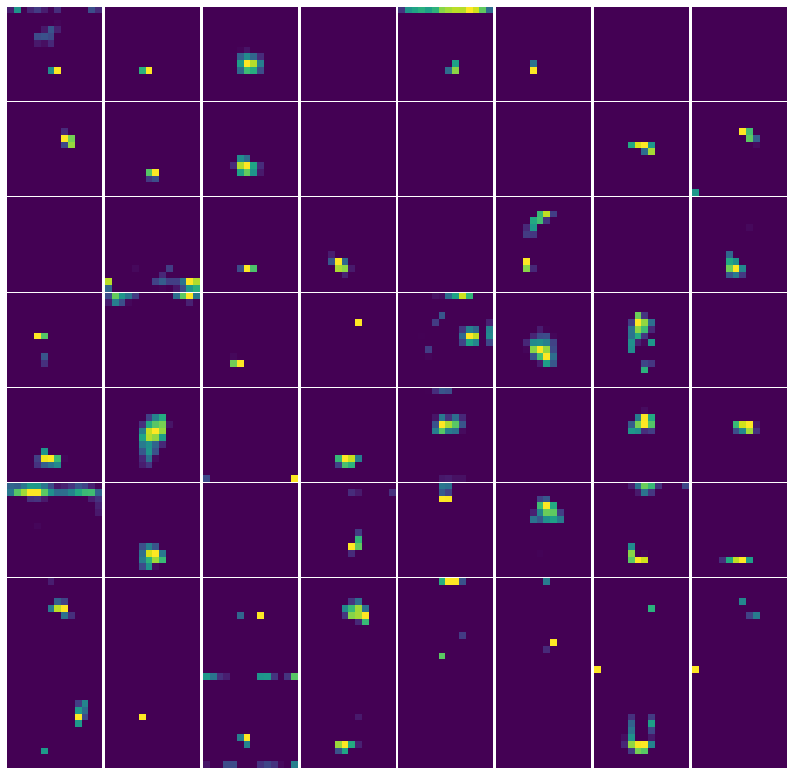

In [59]:
block5=Model(inputs=vgg.inputs,outputs=vgg.get_layer('block5_conv4').output)
block5_features=block5.predict(x)

images =block5_features[0,:,:]
plt.figure(figsize=(14,14))
for n in range(64):
    ax=plt.subplot(8,8,n+1)
    plt.imshow(images[:,:,n])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ImportError: cannot import name 'Dense' from 'tensorflow.keras.models' (/home/craig/anaconda3/envs/test/lib/python3.9/site-packages/tensorflow/keras/models/__init__.py)

In [9]:
#loading dogs and cats data
dir='/home/craig/Documents/coursera/Data/dogs_cats'

images_train = np.load(dir+'/images_train.npy') / 255.
images_valid = np.load(dir+'/images_valid.npy') / 255.
images_test = np.load(dir+'/images_test.npy') / 255.

labels_train = np.load(dir+'/labels_train.npy')
labels_valid = np.load(dir+'/labels_valid.npy')
labels_test = np.load(dir+'/labels_test.npy')
print("{} training data examples".format(images_train.shape[0]))
print("{} validation data examples".format(images_valid.shape[0]))
print("{} test data examples".format(images_test.shape[0]))

600 training data examples
300 validation data examples
300 test data examples


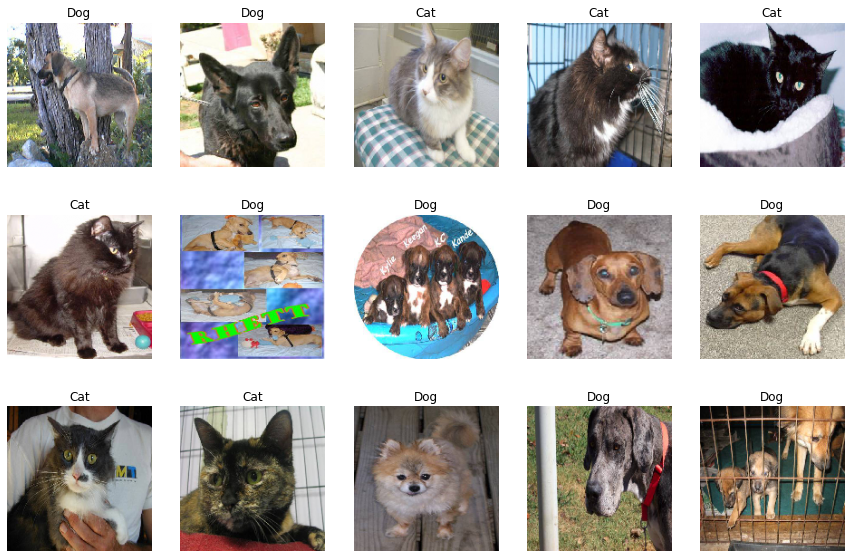

In [10]:
#chekcing out a couple examples
class_names = np.array(['Dog', 'Cat'])
plt.figure(figsize=(15,10))
inx = np.random.choice(images_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(images_train[i])
    plt.title(class_names[labels_train[i]])
    plt.axis('off')

In [17]:
#our base model is vgg, and we will create a transfer learning version using up to and includign the last convolutional
#layer, 
from tensorflow.keras.layers import  Flatten, Dense
headless_vgg=Model(inputs=vgg.inputs,outputs=vgg.get_layer('block5_conv4').output)
headless_vgg.trainable=False

flat1 = Flatten()(headless_vgg.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)
dog_cat_model=Model(inputs=headless_vgg.input,outputs=output)
dog_cat_model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
for layer in dog_cat_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True


In [46]:
x=np.empty((0,224,224,3),dtype='float32')
print(images_train[0].shape)
for im in images_train:
    z=tf.keras.preprocessing.image.smart_resize(im, (224,224), interpolation='bilinear')
    z=np.expand_dims(z,axis=0)
    x=np.append(x,z,axis=0)
print(x.shape)


(160, 160, 3)
(600, 224, 224, 3)


In [47]:
y=np.empty((0,224,224,3),dtype='float32')
print(images_test[0].shape)
for im in images_test:
    z=tf.keras.preprocessing.image.smart_resize(im, (224,224), interpolation='bilinear')
    z=np.expand_dims(z,axis=0)
    y=np.append(y,z,axis=0)
print(y.shape)


(160, 160, 3)
(300, 224, 224, 3)


In [53]:
w=np.empty((0,224,224,3),dtype='float32')
print(images_valid[0].shape)
for im in images_valid:
    u=tf.keras.preprocessing.image.smart_resize(im, (224,224), interpolation='bilinear')
    u=np.expand_dims(u,axis=0)
    w=np.append(u,w,axis=0)
print(w.shape)

(160, 160, 3)
(300, 224, 224, 3)


In [54]:
train_image=x
test_image=y
valid_images=w

In [22]:
from tensorflow.keras.optimizers import SGD

In [55]:
earlystopping = tf.keras.callbacks.EarlyStopping(patience=4)
opt = SGD(lr=0.001, momentum=0.9)
dog_cat_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history_dog= dog_cat_model.fit(train_image, labels_train, epochs=10, batch_size=32,
                                                validation_data=(valid_images, labels_valid), 
                                                callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 151s 8s/step - loss: 0.7065 - accuracy: 0.5877 - val_loss: 0.6830 - val_accuracy: 0.5767
Epoch 2/10
19/19 [==============================] - 157s 8s/step - loss: 0.5080 - accuracy: 0.7557 - val_loss: 0.8163 - val_accuracy: 0.5733
Epoch 3/10
19/19 [==============================] - 158s 8s/step - loss: 0.4511 - accuracy: 0.7463 - val_loss: 0.7367 - val_accuracy: 0.5933


In [ ]:
model_dir='/home/craig/Documents/coursera/models'
model_file=model_dir+'/dogs_cats'
dog_cat_model.save(model_file)